In [1]:
from pykrx import stock
import mpl_finance

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import arrow
import pandas as pd
import numpy as np

pd.set_option('display.max_row', 500)
pd.set_option('display.max_columns', 100)

import warnings
warnings.filterwarnings('ignore')

/Users/minseop/.pyenv/versions/3.8.5/envs/env_stock_bot/lib/python3.8/site-packages/mpl_finance.py:16: DeprecationWarning: 



    Please use `mplfinance` instead (no hyphen, no underscore).

    To install: `pip install --upgrade mplfinance` 

   For more information, see: https://pypi.org/project/mplfinance/


  __warnings.warn('\n\n  ================================================================='+


In [2]:
# constant variables
TRAINING_DAYS = 360
DAYS_FOR_PREDICTION = 7
NUM_BINS = 30

In [3]:
def get_stock_info_dataframe(end_date, start_date, ticker):
    df = stock.get_market_ohlcv_by_date(fromdate=start_date, todate=end_date, ticker=ticker)
    df = df.rename(columns={
                      '시가': 'open',
                      '고가': 'high',
                      '저가': 'low',
                      '종가': 'close',
                      '거래량': 'volume'})

    open_next_day = []
    high_next_day = []
    low_next_day = []
    close_next_day = []
    volume_next_day = []
    
    open_days_ago = []
    high_days_ago = []
    low_days_ago = []
    close_days_ago = []
    volume_days_ago = []

    for ago_days in range(0, DAYS_FOR_PREDICTION):
        open_days_ago.append([])
        high_days_ago.append([])
        low_days_ago.append([])
        close_days_ago.append([])
        volume_days_ago.append([])
    
    
    for i in range(DAYS_FOR_PREDICTION-1, len(df)-1):
        open_next_day.append(df.iloc[i+1]['open'])
        high_next_day.append(df.iloc[i+1]['high'])
        low_next_day.append(df.iloc[i+1]['low'])
        close_next_day.append(df.iloc[i+1]['close'])
        volume_next_day.append(df.iloc[i+1]['volume'])
        
        for ago_days in range(1, DAYS_FOR_PREDICTION):
            open_days_ago[ago_days].append(df.iloc[i-ago_days]['open'])
            high_days_ago[ago_days].append(df.iloc[i-ago_days]['high'])
            low_days_ago[ago_days].append(df.iloc[i-ago_days]['low'])
            close_days_ago[ago_days].append(df.iloc[i-ago_days]['close'])
            volume_days_ago[ago_days].append(df.iloc[i-ago_days]['volume'])

    df = df.iloc[DAYS_FOR_PREDICTION-1:len(df)-1,]

    for ago_days in range(1, DAYS_FOR_PREDICTION):
        df[f'open_{ago_days}day_ago'] = open_days_ago[ago_days]
        df[f'high_{ago_days}day_ago'] = high_days_ago[ago_days]
        df[f'low_{ago_days}day_ago'] = low_days_ago[ago_days]
        df[f'close_{ago_days}day_ago'] = close_days_ago[ago_days]
        df[f'volume_{ago_days}day_ago'] = volume_days_ago[ago_days]
    
    df['open_next_day'] = open_next_day
    df['high_next_day'] = high_next_day
    df['low_next_day'] = low_next_day
    df['close_next_day'] = close_next_day
    df['volume_next_day'] = volume_next_day

    # binning trading volumes
    for col in df.columns:
        if 'volume' in col:
            count, bins_dividers = np.histogram(df[col], bins=NUM_BINS)
            bin_names = [i for i in range(1, NUM_BINS+1)]
            df[col+'_binned'] = pd.cut(x=df[col],
                                       bins=bins_dividers,
                                       labels=bin_names,
                                       include_lowest = True)
            df = df.drop([col],axis='columns')

    return df

In [4]:
def get_today_stock_info_dataframe(end_date, start_date, ticker):
    df = stock.get_market_ohlcv_by_date(fromdate=start_date, todate=end_date, ticker=ticker)
    df = df.rename(columns={
                      '시가': 'open',
                      '고가': 'high',
                      '저가': 'low',
                      '종가': 'close',
                      '거래량': 'volume'})

    df_today = df.iloc[len(df)-1:,:]
    
    open_days_ago = []
    high_days_ago = []
    low_days_ago = []
    close_days_ago = []
    volume_days_ago = []

    for ago_days in range(0, DAYS_FOR_PREDICTION):
        open_days_ago.append([])
        high_days_ago.append([])
        low_days_ago.append([])
        close_days_ago.append([])
        volume_days_ago.append([])

    for ago_days in range(1, DAYS_FOR_PREDICTION):
        open_days_ago[ago_days].append(df.iloc[len(df)-1-ago_days]['open'])
        high_days_ago[ago_days].append(df.iloc[len(df)-1-ago_days]['high'])
        low_days_ago[ago_days].append(df.iloc[len(df)-1-ago_days]['low'])
        close_days_ago[ago_days].append(df.iloc[len(df)-1-ago_days]['close'])
        volume_days_ago[ago_days].append(df.iloc[len(df)-1-ago_days]['volume'])

    for ago_days in range(1, DAYS_FOR_PREDICTION):
        df_today[f'open_{ago_days}day_ago'] = open_days_ago[ago_days]
        df_today[f'high_{ago_days}day_ago'] = high_days_ago[ago_days]
        df_today[f'low_{ago_days}day_ago'] = low_days_ago[ago_days]
        df_today[f'close_{ago_days}day_ago'] = close_days_ago[ago_days]
        df_today[f'volume_{ago_days}day_ago'] = volume_days_ago[ago_days]

    # binning trading volumes
    for col in df_today.columns:
        if 'volume' in col:
            count, bins_dividers = np.histogram(df_today[col], bins=NUM_BINS)
            bin_names = [i for i in range(1, NUM_BINS+1)]
            df_today[col+'_binned'] = pd.cut(x=df_today[col],
                                             bins=bins_dividers,
                                             labels=bin_names,
                                             include_lowest = True)
            df_today = df_today.drop([col],axis='columns')

    return df_today

In [5]:
def draw_candle_chart(df_stock_info, title, postfix=''):
    DATE_TICK_RANGE = int(len(df_stock_info)/9)
    fig = plt.figure(figsize=(16, 8))
    ax = fig.add_subplot(111)
    ax.set_title(title)

    day_list = range(len(df_stock_info))
    name_list = []

    cnt = 0
    for day in df_stock_info.index:
        name_list.append(arrow.get(day).format('YYYY-MM-DD')) if (cnt % DATE_TICK_RANGE == 0 or cnt == len(df_stock_info)-1) else name_list.append('')
        cnt = cnt + 1

    ax.xaxis.set_major_locator(ticker.FixedLocator(day_list))
    ax.xaxis.set_major_formatter(ticker.FixedFormatter(name_list))

    mpl_finance.candlestick2_ohlc(ax, df_stock_info['open'+postfix], df_stock_info['high'+postfix],
                                  df_stock_info['low'+postfix], df_stock_info['close'+postfix], width=0.5, colorup='r', colordown='b')
    plt.show()

In [6]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.model_selection import train_test_split
import random

from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor

from xgboost import XGBRegressor
import time

In [7]:
def model_fitting(df_train):
    x1_train, x1_test, y1_train, y1_test = train_test_split(df_train.loc[:, [col for col in df_train.columns if col not in ['open_next_day', 'high_next_day', 'low_next_day', 'close_next_day', 'volume_next_day_binned']]],
                                                            df_train[['open_next_day', 'high_next_day', 'low_next_day', 'close_next_day']],
                                                            random_state=random.randrange(1, 100))

    pipe = Pipeline([('preprocessing', None), ('regressor', LinearRegression())])
    pre_list = [StandardScaler(), MinMaxScaler(), None]
    hyperparam_grid = [
        {'regressor': [LinearRegression()], 'preprocessing': pre_list},
        {'regressor': [Ridge()], 'preprocessing': pre_list,
         'regressor__alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10]},
        {'regressor': [Lasso()], 'preprocessing': pre_list,
         'regressor__alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10]},
        {'regressor': [LogisticRegression()], 'preprocessing': pre_list,
         'regressor__C': [0.0001, 0.001, 0.01, 0.1, 1, 10]},
        {'regressor': [SVR()], 'preprocessing': pre_list,
         'regressor__epsilon': [0.001, 0.01, 0.1, 1, 10],
         'regressor__C': [0.0001, 0.001, 0.01, 0.1, 1, 10]},
        {'regressor': [MLPRegressor()], 'preprocessing': pre_list,
         'regressor__hidden_layer_sizes': [(100,) , (10, 10, )],
         'regressor__activation': ['relu', 'logistic'],
         'regressor__solver': ['lbfgs', 'adam'],
         'regressor__alpha': [0.0001, 0.01, 1]},
        {'regressor': [XGBRegressor(objective='reg:squarederror')],
         'preprocessing': pre_list,
         'regressor__learning_rate': [0.0, 0.1, 0.09, 0.089, 0.08],
         'regressor__booster': ['gbtree', 'gblinear', 'dart']}

    ]
    kfold = KFold(n_splits=5, shuffle=True, random_state=1)
    grid = GridSearchCV(pipe, hyperparam_grid, scoring='neg_mean_absolute_error',
                        refit=True, cv=kfold)
    grid.fit(x1_train, y1_train)
    print(grid.best_estimator_)
    print(grid.best_params_)
    print(-grid.best_score_)
    
    return grid

In [8]:
# ticker=005930: Samsung Electronics
# ticker=000660: Hynix
def predict_share_price(stock_info: str):
    end_date = arrow.utcnow().shift(hours=9).format('YYYYMMDD')
    start_date = arrow.get(end_date).shift(days=-TRAINING_DAYS).format('YYYYMMDD')

    df = get_stock_info_dataframe(end_date, start_date, stock_info)
    today_df = get_today_stock_info_dataframe(end_date, start_date, stock_info)

    df_train = df.iloc[:len(df)-70]
    df_test = df.iloc[len(df)-70:]

    # training
    start_time = time.time()
    grid = model_fitting(df_train)
    
    print('training time %f sec' % (time.time() - start_time ))

    # test
    df_test = df_test[[col for col in df_test.columns if col not in ['open_next_day', 'high_next_day', 'low_next_day', 'close_next_day', 'volume_next_day_binned']]]
    next_day_prediction = grid.best_estimator_.predict(df_test)

    df_test_curr = df_test.iloc[1:len(df_test)]
    df_test_curr = pd.concat([df_test_curr, today_df])

    columns = ['open_prediction', 'high_prediction', 'low_prediction', 'close_prediction']
    df_test_result = pd.DataFrame(next_day_prediction, columns=columns)
    df_test_result = df_test_result.iloc[0:len(df_test_result)]
    df_test_curr = df_test_curr.drop([col for col in df_test_curr.columns if 'ago' in col], axis=1)

    df_test_result.index = df_test_curr.index
    df_test_merged= pd.concat([df_test_result, df_test_curr], axis=1)

    draw_candle_chart(df_test_merged, 'original chart')
    draw_candle_chart(df_test_merged, 'predicted chart', postfix='_prediction')

    tomorrow_prediction_result = grid.best_estimator_.predict(today_df)
    
    return tomorrow_prediction_result

Pipeline(steps=[('preprocessing', MinMaxScaler()),
                ('regressor', Lasso(alpha=10))])
{'preprocessing': MinMaxScaler(), 'regressor': Lasso(alpha=10), 'regressor__alpha': 10}
717.6334687029107
training time 42.852190 sec


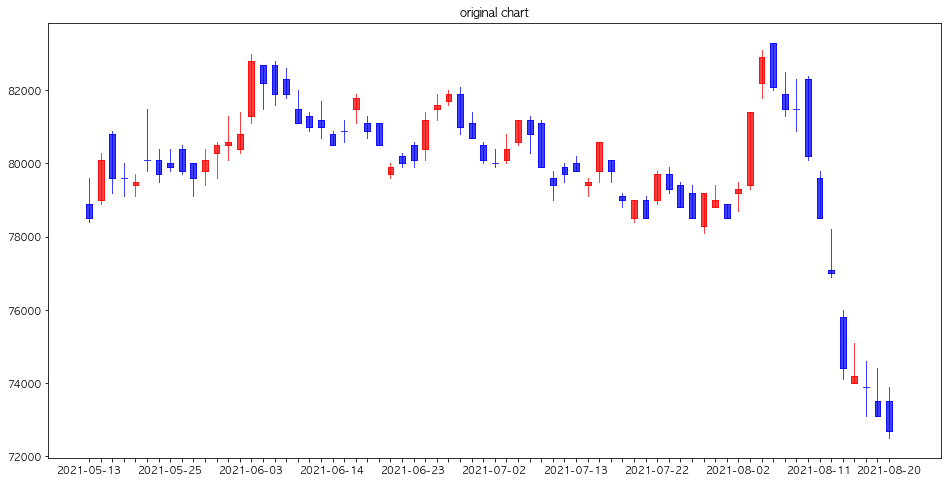

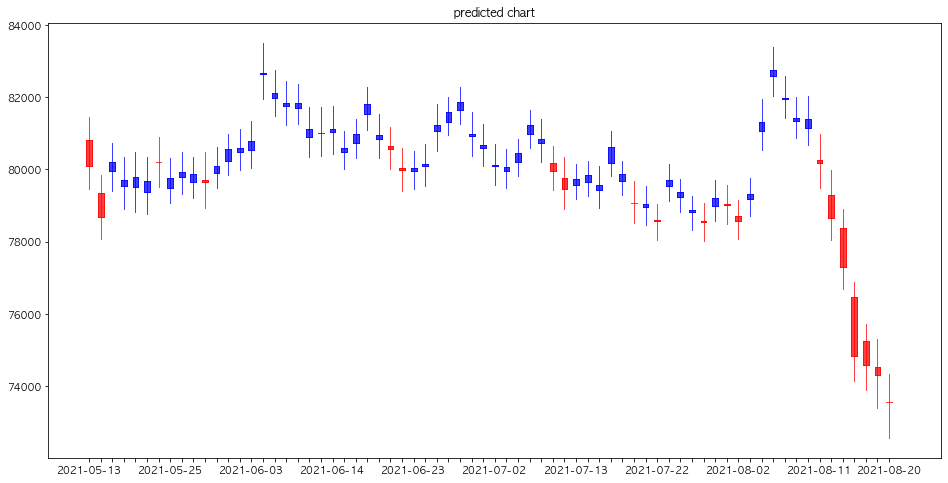

In [9]:
tomorrow_result = predict_share_price('005930')

In [10]:
# open high low close
print(tomorrow_result)

[[73157.74455328 74747.70823973 72061.40400393 73723.88238365]]


In [11]:
# 7일전 open, high, low, close price를 알고 있을 때 다음날의 share price를 예측하는 것이므로 trend 자체는 비슷하게 나온다.
# 하지만 candle의 상하 폭이나, 상승/하락 폭이 근접하게 예측이 안돈다. MSE가 600~700원(주가 1%) 가까이 나오는데,
# 하루 1% 상승이 잘 안나온다는 점에서 신뢰도가 낮다.
# Todo
# model, feature 추가
# 시계열 data에 어울리는 model 적용 필요
# 갑자기 상승하는 다음날 값을 예측하지 못함